# Summary

Our recommender system is different from traditional ones in the aspect of capturing time-based features. Four kinds of features are taken into consideration before implementing our machine learning models: user related features, item related features, user x item related features and time related features. 

Below is the feature engineering process in creating new features we found relevant and useful.

## Feature Engineering

In [1]:
import numpy as np
import pandas as pd


print('loading prior')
priors = pd.read_csv('order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading train')
train = pd.read_csv('order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading orders')
orders = pd.read_csv('orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

print('loading products')
products = pd.read_csv('products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])

print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('train {}: {}'.format(train.shape, ', '.join(train.columns)))

###

print('computing product f')
prods = pd.DataFrame()
prods['orders'] = priors.groupby(priors.product_id).size().astype(np.int32)
prods['reorders'] = priors['reordered'].groupby(priors.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
# del prods


print('add order info to priors')
orders.set_index('order_id', inplace=True, drop=False)
priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)

### user features


print('computing user f')
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

users = pd.DataFrame()
users['total_items'] = priors.groupby('user_id').size().astype(np.int16)
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

users = users.join(usr)
# del usr
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)
print('user f', users.shape)

### userXproduct features

print('compute userXproduct f - this is long...')
priors['user_product'] = priors.product_id + priors.user_id * 100000

# This was to slow !!
#def last_order(order_group):
#    ix = order_group.order_number.idxmax
#    return order_group.shape[0], order_group.order_id[ix],  order_group.add_to_cart_order.mean()
#userXproduct = pd.DataFrame()
#userXproduct['tmp'] = df.groupby('user_product').apply(last_order)

d= dict()
for row in priors.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order)

print('to dataframe (less memory)')
userXproduct = pd.DataFrame.from_dict(d, orient='index')
# del d
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print('user X product f', len(userXproduct))

# del priors

### train / test orders ###
print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

### build list of candidate products to reorder, with features ###

def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%10000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    # del order_list
    # del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('time related features')
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    #df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
    #                                              df.order_id.map(orders.order_dow)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)
    

df_train, labels = features(train_orders, labels_given=True)

f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] # 'dow', 'UP_same_dow_as_last_order'

# del df_train

loading prior
loading train
loading orders
loading products
priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
train (1384617, 4): order_id, product_id, add_to_cart_order, reordered
computing product f
add order info to priors
computing user f
user f (206209, 6)
compute userXproduct f - this is long...
to dataframe (less memory)
user X product f 13293564
split orders : train, test
build candidate list
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
order row 80000
order row 90000
order row 100000
order row 110000
order row 120000
order row 130000
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total

In [4]:
df_train.columns

Index(['order_id', 'product_id', 'user_total_orders', 'user_total_items',
       'total_distinct_items', 'user_average_days_between_orders',
       'user_average_basket', 'order_hour_of_day', 'days_since_prior_order',
       'days_since_ratio', 'aisle_id', 'department_id', 'product_orders',
       'product_reorders', 'product_reorder_rate', 'UP_orders',
       'UP_orders_ratio', 'UP_average_pos_in_cart', 'UP_reorder_rate',
       'UP_orders_since_last', 'UP_delta_hour_vs_last'],
      dtype='object')

In [6]:
df_train3 = df_train
df_train3['label'] = labels
df_train3 = df_train3.dropna()
labels2 = df_train3['label']
df_train3 = df_train3.drop(['label'],axis=1)

## Random Forest

We use random forest regressor to predict the probabiloty of products being purchased. Within the model demonstration we set threshold for this case, so that later on we could export the most likely products being bought for specific user that is above this threshold. We consider different industries or different use cases may require different threshold.

In [77]:
from sklearn.ensemble import RandomForestRegressor
#d_train3 = RandomForestRegressor.DataSet(df_train[f_to_use],
#                      label=labels)

#params = {'n_estimators': 40,
#          'max_depth': 7,
#          'min_samples_split': 8} 

ranf = RandomForestRegressor(n_estimators= 40,
          max_depth= 7,
          min_samples_split= 8)
bst = ranf.fit(df_train3[f_to_use], labels2)

# lgb.plot_importance(bst, figsize=(9,20))
# del d_train

### build candidates list for test ###


df_test, _ = features(test_orders)
preds = bst.predict(df_test[f_to_use])

df_test['pred'] = preds

TRESHOLD = 0.20  # gues
s, should be tuned with crossval on a subset of train data

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub_rf2.csv', index=False)

build candidate list
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              uint8
department_id                         uint8
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                             int16
UP_orders_ratio                     float32
UP_average_pos_in

# Past purchase

In [188]:
order_train = pd.read_csv('order_products__prior.csv')

In [189]:
order_train_user = pd.merge(order_train, orders,how='left', on = 'order_id')

In [190]:
order_train_user2 = pd.merge(order_train_user, products,how='left', on = 'product_id')

In [194]:
order_train_user2 = order_train_user2[['user_id','order_dow','order_hour_of_day','product_name']]

In [201]:
order_train_user2.head(10)

,user_id,order_dow,order_hour_of_day,product_name
0,202279,5,9,Organic Egg Whites
1,202279,5,9,Michigan Organic Kale
2,202279,5,9,Garlic Powder
3,202279,5,9,Coconut Butter
4,202279,5,9,Natural Sweetener
5,202279,5,9,Carrots
6,202279,5,9,Original Unflavored Gelatine Mix
7,202279,5,9,All Natural No Stir Creamy Almond Butter
8,202279,5,9,Classic Blend Cole Slaw
9,205970,5,17,Total 2% with Strawberry Lowfat Greek Strained...


In [205]:
order_train_user2_demo = order_train_user2.loc[order_train_user2['user_id'].isin([827,1659,2514,3397,4238,5002,5746,6581,7393,8225]),:]

In [209]:
order_train_user2_demo.to_csv('order_train_user2_demo.csv')

# Product Recommendation for each user based on time_v1

The function below is to demonstrate what items our system will provide for a specific user.

In [116]:
import numpy as np
import pandas as pd

result = pd.read_csv("sub_rf2.csv")
orders = pd.read_csv('orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})
products = pd.read_csv('products.csv', dtype={
        'product_id': np.uint16,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'product_name', 'department_id'])
aisle = pd.read_csv("aisles.csv")

In [31]:
result_user = pd.merge(result, orders, how='left', on = 'order_id')
#result_user_product = result_user(result_user, products, how='left', on = 'aisle_id')

In [144]:
result.head(5)

,order_id,products
0,2774568,17668 21903 39190 47766 18599 43961 23650 24810
1,1528013,21903 38293
2,1376945,33572 28465 27959 34658 14947 35948 8309 13176
3,1356845,11520 14992 30489 7076 22959 40377 28134 10863...
4,2161313,11266 196 10441 12427 37710 14715 27839


In [141]:
def recommender_item(userid, day, time):
    result = pd.read_csv("sub_rf2.csv", dtype={'order_id': np.int32})
    orders = pd.read_csv('orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})
    result_user = pd.merge(result, orders, how='left', on = 'order_id')

    return np.array(result_user.loc[(result_user['user_id'] == userid) & (result_user['order_dow'] == day) & (result_user['order_hour_of_day'] == time), 'products'])

def recommmender_item_name():
    product_lst = [x.split() for x in recommender_item(userid, day, time)][0]
    product_lst = list(map(int, product_lst))
    products = pd.read_csv('products.csv', dtype={
        'product_id': np.uint16,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'product_name', 'department_id'])
    return products.loc[products['product_id'].isin(product_lst), 'product_name']

In [172]:
result_user.shape

(4649887, 10)

In [104]:
recommender_item(3, 5, 15)

array(['17668 21903 39190 47766 18599 43961 23650 24810'], dtype=object)

In [142]:
userid = 3
day =5
time = 15
recommmender_item_name()

17667    Unsweetened Chocolate Almond Breeze Almond Milk
18598                                    Garlic Couscous
21902                               Organic Baby Spinach
23649                                  Electrolyte Water
24809            Organic Lightly Salted Brown Rice Cakes
39189                    Vanilla Unsweetened Almond Milk
43960                  Organic Peeled Whole Baby Carrots
47765                                    Organic Avocado
Name: product_name, dtype: object

# Product Recommendation for each user based on time_v2

In [146]:
predictions = pd.read_csv("predictions.csv", dtype={'order_id': np.int32})

In [173]:
result_user = pd.merge(predictions, orders, on = 'order_id')

In [222]:
result_user[result_user['user_id'] == 3397]

,Unnamed: 0,order_id,product_id,pred,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
77122,77122,1850480,23296,0.085804,3397,test,12,6,21,30.0
77123,77123,1850480,4605,0.087605,3397,test,12,6,21,30.0
77124,77124,1850480,47234,0.018733,3397,test,12,6,21,30.0
77125,77125,1850480,3330,0.032844,3397,test,12,6,21,30.0
77126,77126,1850480,45064,0.033076,3397,test,12,6,21,30.0
77127,77127,1850480,47368,0.084095,3397,test,12,6,21,30.0
77128,77128,1850480,34184,0.182729,3397,test,12,6,21,30.0
77129,77129,1850480,13834,0.294603,3397,test,12,6,21,30.0
77130,77130,1850480,33548,0.231109,3397,test,12,6,21,30.0
77131,77131,1850480,37646,0.164148,3397,test,12,6,21,30.0


In [179]:
result_user.shape

(4649887, 10)

In [159]:
result_user2 = pd.merge(result_user, products, how='left', on = 'product_id')

In [ ]:
result_user2

In [169]:
arr = result_user2.loc[(result_user2['user_id'] == 3) & (result_user2['order_dow'] == 5) & (result_user2['order_hour_of_day'] == 15)]

In [181]:
arr.sort_values(by=['pred'], ascending=False)[['product_name','pred']]

,product_name,pred
9,Vanilla Unsweetened Almond Milk,0.764788
10,Organic Avocado,0.671578
3,Organic Baby Spinach,0.640171
15,Garlic Couscous,0.419329
0,Unsweetened Chocolate Almond Breeze Almond Milk,0.322892
19,Organic Peeled Whole Baby Carrots,0.322557
28,Electrolyte Water,0.296465
29,Organic Lightly Salted Brown Rice Cakes,0.216176
6,"Crackers, Crispy, Cheddar",0.163074
17,Granny Smith Apples,0.131935


In [184]:
import matplotlib.pyplot as plt

,pred
product_name,
Vanilla Unsweetened Almond Milk,0.764788
Organic Avocado,0.671578
Organic Baby Spinach,0.640171
Garlic Couscous,0.419329
Unsweetened Chocolate Almond Breeze Almond Milk,0.322892


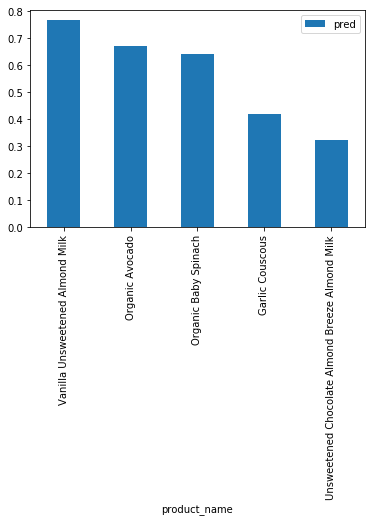

In [193]:
def recommender_item(userid, day, time):
    predictions = pd.read_csv("predictions.csv", dtype={'order_id': np.int32})
    orders = pd.read_csv('orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})
    result_user = pd.merge(predictions, orders, on = 'order_id')
    result_user2 = pd.merge(result_user, products, on = 'product_id')
    
    df = result_user2.loc[(result_user2['user_id'] == userid) & (result_user2['order_dow'] == day) & (result_user2['order_hour_of_day'] == time)]
    df_sort = df.sort_values(by=['pred'], ascending=False)[['product_name','pred']]
    df_sort_top5 = df_sort.head(5)
    df_sort_top5 = df_sort_top5.set_index('product_name')
    
    plt = df_sort_top5.plot(kind='bar', label = 'product_name')
    return df_sort_top5

,pred
product_name,
Roma Tomato,0.671403
Canola Oil Non Stick Cooking Spray,0.516020
Nutz Over Chocolate,0.433800
Albacore White Tuna Pouch,0.422636
Singles 2% Milk American Cheese Slices,0.417035


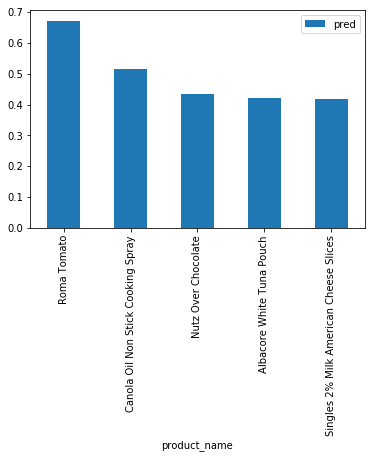

In [223]:
recommender_item(3397, 6, 21)